## Optimizing gold extraction from mined ore using Machine Learning
The Zyfra Group develops and implements industrial digital solutions to improve efficiency and safety of the mining, oil & gas, chemical industries. In this project, Zyfra has requested a prototype machine learning model to optimize production of gold from gold ore and eliminate unprofitable parameters.

#### Task Statement

Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry. The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification. The model will help to optimize the production and eliminate unprofitable parameters.

## Data description
#### Technological process

- Rougher feed — raw material
- Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
- Xanthate — promoter or flotation activator;
- Sulphate — sodium sulphide for this particular process;
- Depressant — sodium silicate.
- Rougher process — flotation
- Rougher tails — product residues
- Float banks — flotation unit
- Cleaner process — purification
- Rougher Au — rougher gold concentrate
- Final Au — final gold concentrate

#### Parameters of stages

- air amount — volume of air
- fluid levels
- feed size — feed particle size
- feed rate

The stages of the technological process for gold extraction from ore is shown

In [1]:
from IPython.display import Image
Image(url='https://pythondance.s3.us-west-2.amazonaws.com/Gold_extraction_process.JPG', width = 600, height = 300)

### Objectives
The objectives of this project are to:

1. Simulate the gold recovery process from gold ore
2. Develop a model to predict the amount of gold recovered and optimize gold production
3. Predict final sMAPE metric

## Open the data file and study the general information

We require the following libraries: pandas and numpy for data preprocessing and manipulation, Scikit-Learn for building our learning algorithms

In [24]:
#Let us first import the relevant libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from joblib import dump
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from sklearn.model_selection import cross_val_score

# import time for time computation
import timeit

from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier

#Adding this first up to make sure we don't need to see warnings to make outputs look nice
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [3]:
#Now, let us load the data
train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train.csv')

test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test.csv')

full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full.csv')

In [4]:
#All helper functions are created in this code chunk to keep the rest of the report neat

#This function gives us a premilinary glimpse into the data
def inspect_data(df):
    print(df.head())
    print(df.isna().sum())
    print(df.info())
    print(df.describe())

#This function prints the names of the column that have the string that has been passed as an argument and returns the 
#dataframe with only the columns that have those strings in it's name.
def cols_with_str(df, string):
    cols = [col for col in df.columns if string in col]
    print(list(df[cols]))
    return df[cols]

#This function calculates recovery. You need to provide the string names of the columns used for calculation.
#Function returns the column with NAs dropped.
def recover_calculation(df,c,f,t):
    cal = 100 * (df[c] * (df[f] - df[t])) / (df[f] * (df[c] - df[t]))
    return cal

#This function removes the rows with NAs in a 'union' method so that the mae calculation can be done with columns that
#have the same number of elements. Returns a dataframe that contains both columns.
def dropna_mult(a,b):
    df = pd.DataFrame({'a':a,'b':b}).dropna()
    return df



def rougher_feed(df, metal, rougher, feed, inpu):
    
    au_rougher = cols_with_str(train,metal)
    au_rougher = cols_with_str(au_rougher,rougher)
    au_rougher = cols_with_str(au_rougher,feed)
    au_rougher = cols_with_str(au_rougher,inpu)
    #print(au_rougher)
    mean = au_rougher.mean()
    return mean[0]

def concentrate_sum(df,drop1,drop2):
    rougher_input_feed = cols_with_str(full,'rougher.input.feed')
    #print(rougher_input_feed)
    rougher_input_feed = rougher_input_feed.drop(drop1,axis=1)
    rougher_input_feed = rougher_input_feed.drop(drop2,axis=1)
    #print(rougher_input_feed.columns)
    #full[rougher_input_feed.columns].sum(1).hist(20)
    return list(df[rougher_input_feed.columns])

def smape_helper(target, predicted):
    ratio = np.divide(np.abs(target - predicted), (np.abs(target)+np.abs(predicted))/2)
    value = np.average(ratio, axis=0)
    return value

def smape(targeted,predicted):
    smape_rougher = smape_helper(targeted[target.index('rougher.output.recovery')], predicted[target.index('rougher.output.recovery')])
    smape_final = smape_helper(targeted[target.index('final.output.recovery')], predicted[target.index('final.output.recovery')])
    value = 0.25*smape_rougher + 0.75*smape_final
    return value
def lin_reg(features_train, features_test, target_train, target_test):
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_test= scaler.transform(features_test)
    lr = LinearRegression().fit(features_train,target_train)
    predicted_values = lr.predict(features_test)
    smape = cross_val_score(lr, features_train, target_train, cv=5, scoring=smape_scorer)
    print("average smape:", smape.mean())
    print('R2', lr.score(features_test, target_test))
    print('RMSE:', np.sqrt(mean_squared_error(target_test, predicted_values)))
    print('Average Volume of Predicted Reserve:',predicted_values.mean() )
    
def dec_tree_mod(features_train, features_test, target_train, target_test):
    depth_param = {'max_depth': range(6,12,2)}
    DecTreeMod = DecisionTreeRegressor(random_state=12345)
    DecTreeModOpt = GridSearchCV(DecTreeMod,depth_param, scoring=smape_scorer, cv=5)
    DecTreeModOpt.fit(features_train, target_train)
    print(DecTreeModOpt.best_estimator_)
    smape = cross_val_score(DecTreeModOpt, features_train, target_train, cv=5, scoring=smape_scorer)
    print("average smape:", smape.mean())
    DecTreeModOpt_predicted_test = DecTreeModOpt.predict(features_test)
    print('Accuracy:', DecTreeModOpt.score(features_test, target_test))

def rand_for_mod(features_train, features_test, target_train, target_test):
    param = {'n_estimators':range(1,100,20)}
    RandForestOpt = GridSearchCV(RandomForestRegressor(random_state=12345,max_depth = 9), param_grid=param,scoring=smape_scorer, cv=5, refit=True)
    RandForestOpt.fit(features_train, target_train)
    print(RandForestOpt.best_estimator_)
    smape = cross_val_score(RandForestOpt, features_train, target_train, cv=3, scoring=smape_scorer)
    print("average smape:", smape.mean())
    RandForestOpt_predicted_test = RandForestOpt.predict(features_test)
    print('Accuracy:', RandForestOpt.score(features_test, target_test))
    

def dum_reg(features_train, features_test, target_train, target_test):
    dummy = DummyRegressor(strategy='mean').fit(features_train, target_train)
    target_pred = dummy.predict(features_test)
    print('smape:', smape(target_test, target_pred))

All functions required for this report have been written in this chunk.

In [5]:
inspect_data(train)

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

In [6]:
inspect_data(test)

                  date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   
2  2016-09-01 02:59:59                     215.259946   
3  2016-09-01 03:59:59                     215.336236   
4  2016-09-01 04:59:59                     199.099327   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                        0.990469                             1398.777

In [7]:
inspect_data(full)

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

#### Conclusion
These are some huge datasets. There are many possible issues and existence of null values. Let's deal with them as needed based on tasks that come.

## Data Preprocessing
##### Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

In [8]:
output_rougher = pd.DataFrame({"output_recovery":train["rougher.output.recovery"],"calc":rougher_output_recovery_calc}).dropna()
MAE = dropna_mult(output_rougher["output_recovery"],output_rougher["calc"])
print(f"MAE={MAE}")

NameError: name 'rougher_output_recovery_calc' is not defined

In [ ]:
C = 'rougher.output.concentrate_au'
F = 'rougher.input.feed_au'
T = 'rougher.output.tail_au'
rec_calc = recover_calculation(train,C,F,T)
mae = dropna_mult(rec_calc,train["rougher.output.recovery"])
mae= mean_absolute_error(mae['a'],mae['b'])
print('Mean Absolute Error:',mae)

We have obtained a Mean Absolute Error of 1.0724115653039479e-14. This is a very small deviation which implies that the recovery is calculated correctly.

##### Analyze the features not available in the test set. What are these parameters? What is their type?

In [ ]:
not_in_test = full.columns.difference(test.columns)
full[not_in_test].head()
full[not_in_test].isna().sum()

#### Conclusion
There are almost 50 features, and a lot of them have NA values. Again, based on the project need we will deal with them in the way required.

As I did the project, I later realized that some important target attributes were missing. I dealt with that at that stage.

## Analyze The Data
Study how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage

In [ ]:
#Let us create vectors for each element for each stage we care about.
au_rougher_feed_input = rougher_feed(full,'au','rougher','feed', 'input')
ag_rougher_feed_input = rougher_feed(full,'ag','rougher','feed', 'input')
pb_rougher_feed_input = rougher_feed(full,'pb','rougher','feed', 'input')
au_final_output_tail = rougher_feed(full,'au','final','output', 'tail')
ag_final_output_tail = rougher_feed(full,'ag','final','output', 'tail')
pb_final_output_tail = rougher_feed(full,'pb','final','output', 'tail')
au_rougher_output_tail = rougher_feed(full,'au','rougher','output', 'tail')
ag_rougher_output_tail = rougher_feed(full,'ag','rougher','output', 'tail')
pb_rougher_output_tail = rougher_feed(full,'pb','rougher','output', 'tail')
au_primary_output_concentrate = rougher_feed(full,'au','primary','output','concentrate')
ag_primary_output_concentrate = rougher_feed(full,'ag','primary','output','concentrate')
pb_primary_output_concentrate = rougher_feed(full,'pb','final','output','concentrate')
au_final_output_concentrate = rougher_feed(full,'au','final','output','concentrate')
ag_final_output_concentrate = rougher_feed(full,'ag','final','output','concentrate')
pb_final_output_concentrate = rougher_feed(full,'pb','final','output','concentrate')

In [ ]:
plt.figure(figsize=(13,8), dpi= 100, facecolor='w', edgecolor='k')
labels = ['Au', 'Ag', 'Pb']
bars1 = [au_rougher_feed_input, au_final_output_tail,au_rougher_output_tail, au_primary_output_concentrate, au_final_output_concentrate]
bars2 = [ag_rougher_feed_input, ag_final_output_tail,ag_rougher_output_tail, ag_primary_output_concentrate, ag_final_output_concentrate]
bars3 = [pb_rougher_feed_input, pb_final_output_tail,pb_rougher_output_tail, pb_primary_output_concentrate, pb_final_output_concentrate]

barWidth = 0.25

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Au')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Ag')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='Pb')
 
# Add xticks on the middle of the group bars
plt.xlabel('Stage', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Rougher input feed', 'Final_output_tail', 'Rougher output tail','Primary Output Concentrate', 'Final Output Concentrate'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

### Conclusion:
I see that:

- the mean concentration of "AU" is increasing on the every step.
- the mean concentration of "AG" increased after flotation. But it decreased after purification process.
- the mean concentration of "PB" is increasing on the every step.

##### Compare the feed particle size distributions in the training set and in the test set

In [ ]:
print(train['rougher.input.feed_size'].describe())
print(test['rougher.input.feed_size'].describe())
train['rougher.input.feed_size'].hist(density=True)
plt.title('Density of Rougher.input.feed_size')
plt.show();

In [ ]:
test['rougher.input.feed_size'].hist(density=True)
plt.title('Density of Rougher.input.feed_size')
plt.show();

In [ ]:
rougher_names = concentrate_sum(full, 'rougher.input.feed_rate', 'rougher.input.feed_size')
full[rougher_names].sum(1).hist()
rougher = full[rougher_names]
#Let us remove rows with only 0
a_series = (rougher != 0).any(axis=1)

rougher = rougher.loc[a_series]
plt.show();

In [ ]:
rougher.sum(1).hist()
plt.show();

In [ ]:
rougher_output_names = cols_with_str(full,'rougher.output.concentrate').columns
full[rougher_output_names].sum(1).hist()

rougher_output = full[rougher_output_names]
#Let us remove rows with only 0
a_series = (rougher_output != 0).any(axis=1)

rougher_output = rougher_output.loc[a_series]

In [ ]:
rougher_output.sum(1).hist()
plt.show();

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']


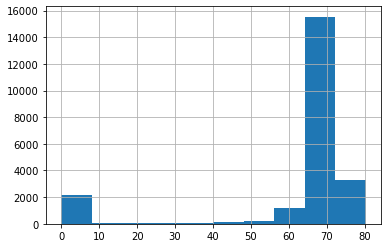

In [9]:
final_output_names = cols_with_str(full,'final.output.concentrate').columns
full[final_output_names].sum(1).hist()
plt.show();

In [10]:
final_output = full[final_output_names]
#Let us remove rows with only 0
a_series = (final_output != 0).any(axis=1)

final_output = final_output.loc[a_series]

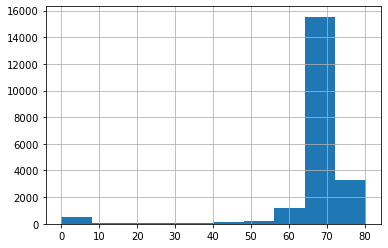

In [11]:
final_output.sum(1).hist()
plt.show();

#### Conclusion
Above, we plotted histograms before and after letting the null value rows stay. It made noticeable differences, hopefully this is good enough for the model.

## Build the model
##### Write a function to calculate the final sMAPE value.
The function has been written in the helper functions section of this notebook.

##### Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.
To solve the problem, we will need a new metric. It is called sMAPE, symmetric Mean Absolute Percentage Error. It is similar to MAE, but is expressed in relative values instead of absolute ones. Why is it symmetrical? It equally takes into account the scale of both the target and the prediction.

We will train a linear regression, decision tree and random forest models. We will also do a dummy regression to see how the models compare to a baseline.

In [12]:
target = ['rougher.output.recovery', 'final.output.recovery']
features = list(set(train.columns).intersection(set(test.columns)).difference(set(target)))

#date is not going to be a useful feature, so let's remove it
features.remove('date')

#Before we go further, we have to remember that the target variables are not in our test dataset. Let's use the full
#data to put it in the test data.

test = test.merge(full[['final.output.recovery', 'rougher.output.recovery']], how='left', left_index=True, right_index=True)
train = train.dropna()
test = test.dropna()

In [14]:
features_train, features_test = train[features].values, test[features].values
target_train, target_test = train[target].values, test[target].values

In [20]:
# function to compute the sMAPE
def smape(y_true, y_pred):
    smape = (np.abs(y_true - y_pred)/((np.abs(y_true) + np.abs(y_pred))/2)).mean()
    return smape

# function to calculate the final sMAPE value
def smape_final(y_true, y_pred):
    smape_out_rougher = smape(y_true[:,0], y_pred[:,0])
    smape_out_final = smape(y_true[:,1], y_pred[:,1])
    return ((0.25 * smape_out_rougher) + (0.75 * smape_out_final))

# user-defined scoring function
smape_score = make_scorer(smape_final)

##### Baseline Model

In [21]:
# baseline model using a dummy regressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
dummy_regr_test_predictions = dummy_regr.predict(features_test)

In [22]:
# evaluate baseline model
smape_final(target_test, dummy_regr_test_predictions)

0.11420314934872655

Looking at this, our baseline final sMAPE score is 11.4. Let's try to improve on this by training other algorithms. We develop other models and tune the hyperparameters accordingly.

##### Linear Regression Model

In [25]:
# build model
start_time = timeit.default_timer()
lr_regr = LinearRegression().fit(features_train, target_train) # train the model 
lr_regr_test_predictions = lr_regr.predict(features_test)

# cross-validation for linear model
cv_score_lr = cross_val_score(lr_regr, features_train, target_train, cv=5, scoring=smape_score)
print('Mean smape:  {:.2%}'.format(cv_score_lr.mean()))
print('sMAPE range of values are: ', cv_score_lr)
print()
print('Execution time: ' + str((timeit.default_timer() - start_time)) + ' mins')

Mean smape:  10.29%
sMAPE range of values are:  [0.11327987 0.08886104 0.09270128 0.10787246 0.11183018]

Execution time: 0.19384132999994108 mins


In [26]:
# compute final smape for linear regression
print('The final sMAPE score is: {:.2%}'.format(smape_final(target_test, lr_regr_test_predictions)))

The final sMAPE score is: 13.24%


##### Random Forest Regression Model

Let's build the random forest regressor with and without hyperparameter tuning. For multi-label regression, we would use Decision trees and Random forest algorithms as our machine learning models.

In [27]:
# build random forest regression model
start_time = timeit.default_timer()
rf_regr = RandomForestRegressor().fit(features_train, target_train) # train the model 
rf_regr_test_predictions = rf_regr.predict(features_test)

# cross-validation for random forest regression
cv_score_rf = cross_val_score(rf_regr, features_train, target_train, cv=5, scoring=smape_score)
print('Mean smape:  {:.2%}'.format(cv_score_rf.mean()))
print('sMAPE range of values are: ', cv_score_rf)
print()
print("Execution time: " + str((timeit.default_timer() - start_time)/60) + ' mins')

Mean smape:  11.10%
sMAPE range of values are:  [0.09365754 0.1239613  0.08749366 0.12469153 0.12540881]

Execution time: 4.3845255491833335 mins


In [28]:
# compute final smape for random forest
print('The final sMAPE score is: {:.2%}'.format(smape_final(target_test, rf_regr_test_predictions)))

The final sMAPE score is: 12.48%


##### Random forest with hyperparameter tuning
Using grid search to find the hyperparameters for the random forest algorithm, we have:

In [29]:
# define the cross validation scheme
for i in [10, 25, 50]:
    rf = RandomForestRegressor(n_estimators = i, random_state = 12345)
    rf.fit(features_train, target_train)
    cross_val_scores_rf = cross_val_score(rf, features_train, target_train, cv=5, scoring=smape_score)
    print('n_estimators: ' + str(i) + ', Mean smape: {:.4%}'.format(cross_val_scores_rf.mean()))

n_estimators: 10, Mean smape: 13.0741%
n_estimators: 25, Mean smape: 11.8859%
n_estimators: 50, Mean smape: 11.6590%


In [30]:
start_time = timeit.default_timer()
# hyperparameter optimization

# define hyperparameters to tune
grid = {
    "n_estimators" : [10, 25, 50]
}
# define the model 
regressor = RandomForestRegressor(random_state = 12345)
# define the grid search
grid_search_rf = GridSearchCV(estimator = regressor, param_grid = grid, scoring=smape_score)
# execute search
grid_search_rf.fit(features_train, target_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_rf.best_params_))
print()
print("Execution time: " + str((timeit.default_timer() - start_time)/60) + ' mins')

The best hyperparameters are: {'n_estimators': 10}

Execution time: 3.1010180581666646 mins


In [31]:
# create the random forest regressor model
def random_forest_regressor(X_train, y_train, X_test, y_test):
    """
    This is a random forest regressor function developed to train
    the model, make prediction on testing dataset, 
    and compute evaluation metrics for testing datasets
    """
    # build the model
    model = RandomForestRegressor(**grid_search_rf.best_params_)
    model.fit(X_train, y_train) # train the model 
    # make predictions on testing set
    rf_test_predictions = model.predict(X_test)
    
    # compute final smape for random forest
    print('The final sMAPE is: {:.2%}'.format(smape_final(target_test, rf_test_predictions)))

In [32]:
# determine final sMAPE for random forest regressor
random_forest_regressor(features_train, target_train, features_test, target_test)

The final sMAPE is: 13.31%


We can see an increase in the final sMAPE score, and the execution time decreased. The larger the grid to search, the more execution time it take for the algorithm to run.

##### Decision Tree Regression model

In [33]:
# build decision tree regression model
start_time = timeit.default_timer()
dt_regr = DecisionTreeRegressor().fit(features_train, target_train) # train the model 
dt_regr_test_predictions = dt_regr.predict(features_test)

# cross-validation for decision tree regression
cv_score_dt = cross_val_score(dt_regr, features_train, target_train, cv=5, scoring=smape_score)
print('Mean smape:  {:.4%}'.format(cv_score_dt.mean()))
print('sMAPE range of values are: ', cv_score_dt)
print()
print("Execution time: " + str((timeit.default_timer() - start_time)/60) + ' mins')

Mean smape:  nan%
sMAPE range of values are:  [0.22202578 0.19142488 0.13287387        nan 0.19403686]

Execution time: 0.09692364353333384 mins


In [34]:
# compute final smape for decision tree model
print('The final sMAPE score is: {:.2%}'.format(smape_final(target_test, dt_regr_test_predictions)))

The final sMAPE score is: 15.96%


##### Decision Tree with hyperparameter tuning

In [35]:
# define the cross validation scheme
for i in [2, 4, 8, 16]:
    dt = DecisionTreeRegressor(max_depth = i, random_state = 12345)
    dt.fit(features_train, target_train)
    cross_val_scores_dt = cross_val_score(dt, features_train, target_train, cv=5, scoring=smape_score)
    print('Max depth: ' + str(i) + ', Mean smape: {:.4%}'.format(cross_val_scores_dt.mean()))

Max depth: 2, Mean smape: 9.2568%
Max depth: 4, Mean smape: 9.8451%
Max depth: 8, Mean smape: 10.7235%
Max depth: 16, Mean smape: 18.3586%


In [36]:
start_time = timeit.default_timer()
# hyperparameter optimization

# define hyperparameters to tune
params_ = {
    "max_depth" : [2, 4, 8, 16],
    "min_samples_split" : [2, 4, 8, 16]
    }
# define the model
dt_regressor = DecisionTreeRegressor()

# define the grid search
grid_search_dt = GridSearchCV(estimator = dt_regressor, param_grid = params_, scoring=smape_score)
# execute search
grid_search_dt.fit(features_train, target_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_dt.best_params_))
print()
print("Execution time: " + str((timeit.default_timer() - start_time)/60) + ' mins')

The best hyperparameters are: {'max_depth': 16, 'min_samples_split': 2}

Execution time: 0.4817889017499965 mins


In [37]:
# create the decision tree regressor model
def decision_tree_regressor(X_train, y_train, X_test, y_test):
    """
    This is a decision tree regressor function developed to train
    the model, make prediction on testing dataset, 
    and compute evaluation metrics for testing datasets
    """
    # build the model
    dt_model = DecisionTreeRegressor(**grid_search_dt.best_params_)
    dt_model.fit(X_train, y_train) # train the model 
    # make predictions on testing set
    dt_test_predictions = dt_model.predict(X_test)
    
    # compute final smape for decision tree regressor
    print('The final sMAPE is: {:.2%}'.format(smape_final(target_test, dt_test_predictions)))

In [38]:
# determine final sMAPE for decision tree regressor
decision_tree_regressor(features_train, target_train, features_test, target_test)

The final sMAPE is: 15.36%


With the decision tree regressor, we obtained an sMAPE score of 15.96% using cross validation. When we tuned various hyperparameters, the sMAPE score decreased to 15.36% showing that tuning the hyperparameters did not achieve a better sMAPE score. A summary of the result showing the final sMAPE is shown below:

|Regressor |	Final sMAPE w/o tuning|	Final sMAPE with tuning |
| --- | --- | --- |
|Dummy|	11.4%|	-|
|LinearRegressor	|	13.24%|-|
|RandomForest|	11.1%|	13.31%|
|DecisionTree| 15.96%| 15.36% |

## Overall conclusion

In building the model, we wrote a function to calculate the final sMAPE value. We trained different models, evaluated them using cross-validation, and did some hyperparameter tuning. We tested the model using the test sample. We observed that the best performing model is the Random forest regressor followed by the linear regression model. We also observed that tuning the hyperparameters did not lead to significant improvement of the final sMAPE value. Infact the final sMAPE score with hyperparameter tuning showed significant increase than the final sMAPE score without tuning. If the goal is to minimize the score then the onus lies with the data scientist to decide on whether to tune or not. In summary, the best performing model is the Dummy Model based on the final sMAPE metric. This model was able to predict the amount of gold recovered and optimize gold production.